### Mount Google Drive in Colab


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Dataset Preparation and Augmentation


In [15]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight


# Setting Up Paths
ZIP_PATH = '/content/drive/MyDrive/Dataset/dataset.zip'
EXTRACT_PATH = '/content/dataset'
BASE_PATH = os.path.join(EXTRACT_PATH, 'BVD')
TRAIN_PATH = os.path.join(BASE_PATH, 'Train')
VAL_PATH = os.path.join(BASE_PATH, 'Val')
TEST_PATH = os.path.join(BASE_PATH, 'Test')

os.makedirs(EXTRACT_PATH, exist_ok=True)

# Extract Dataset
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_PATH)

# Data Augmentation and Generators
IMG_SIZE = 224
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Compute Class Weights
labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))


Found 547 images belonging to 2 classes.
Found 59 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


### Load, Customize, and Train ResNet50V2 Model


In [3]:
# Load the ResNet50V2 Model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    class_weight=class_weights,
    verbose=1
)



94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5649 - loss: 0.8568 - val_accuracy: 0.8475 - val_loss: 0.3688
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.7926 - loss: 0.4872 - val_accuracy: 0.9153 - val_loss: 0.1643
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.8835 - loss: 0.3012 - val_accuracy: 0.9831 - val_loss: 0.0793
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step - accuracy: 0.9177 - loss: 0.2253 - val_accuracy: 0.9661 - val_loss: 0.0746
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 346ms/step - accuracy: 0.9015 - loss: 0.2371 - val_accuracy: 0.9831 - val_loss: 0.0703
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - accuracy: 0.9213 - loss: 0.2115 - val_accuracy: 1.0000 - val_loss: 0.0192
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.9342 - loss: 0.2047 - val_accuracy: 0.9831 - val_loss: 0.0353
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 344ms/step - accuracy: 0.9488 - loss: 0.1630 - val_accuracy: 1.0000 

### Model Evaluation: Accuracy, Confusion Matrix, Classification Report, and Metrics (Precision, Recall, F1-Score)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9634 - loss: 0.1146
Test accuracy: 0.9545
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


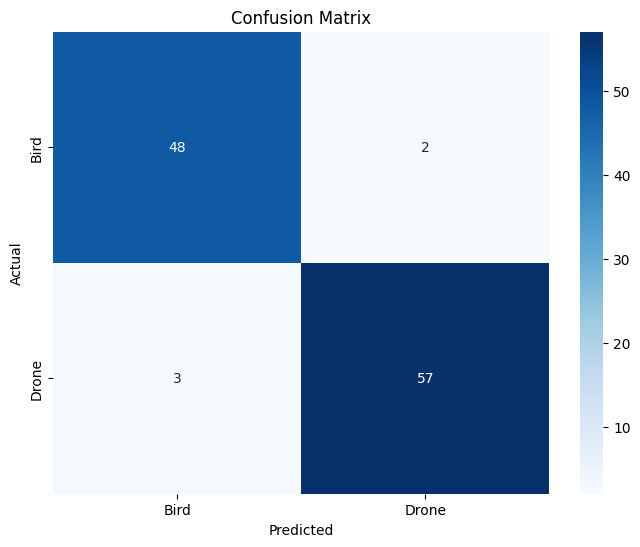

Classification Report:
               precision    recall  f1-score   support

        Bird       0.94      0.96      0.95        50
       Drone       0.97      0.95      0.96        60

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110

Precision: 0.9548
Recall: 0.9545
F1-Score: 0.9546


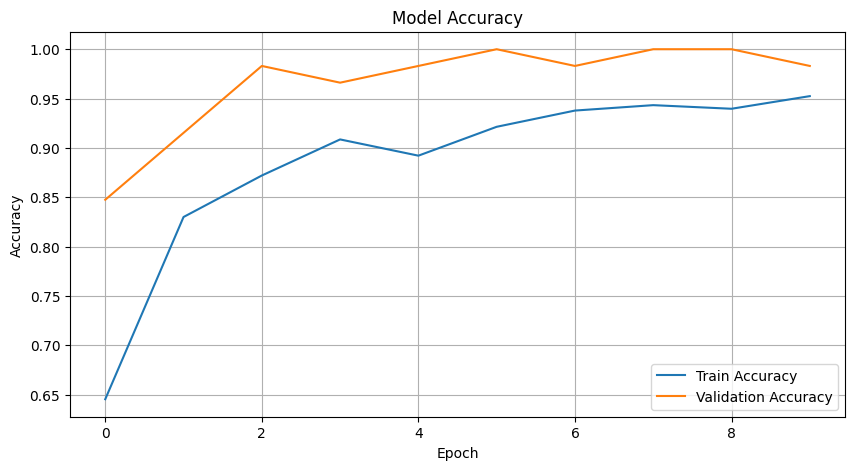

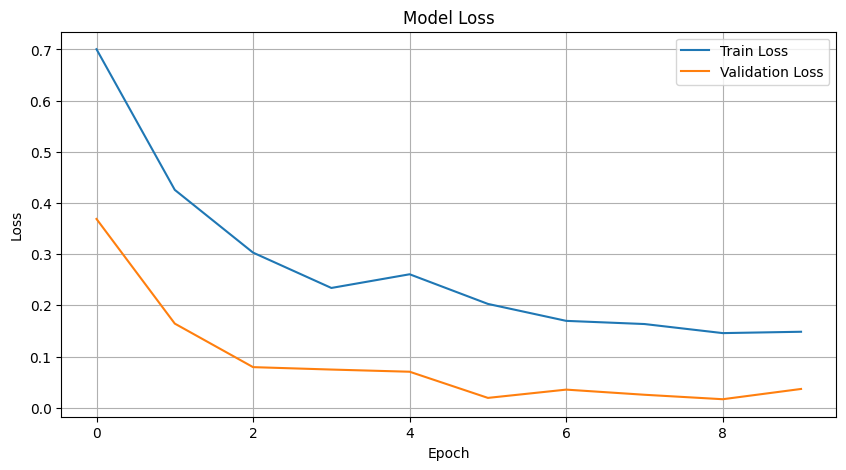

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Evaluate the Model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy:.4f}')

# Confusion Matrix
test_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
target_names = list(test_generator.class_indices.keys())
classification_report_str = classification_report(test_labels, predicted_classes, target_names=target_names)
print("Classification Report:\n", classification_report_str)

# Precision, Recall, F1-Score
precision = precision_score(test_labels, predicted_classes, average='weighted')
recall = recall_score(test_labels, predicted_classes, average='weighted')
f1 = f1_score(test_labels, predicted_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()


### Saving the Trained Model to Google Drive

In [14]:
model.save('/content/drive/MyDrive/model.h5')

### Visualizing Random Test Images with Actual and Predicted Labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


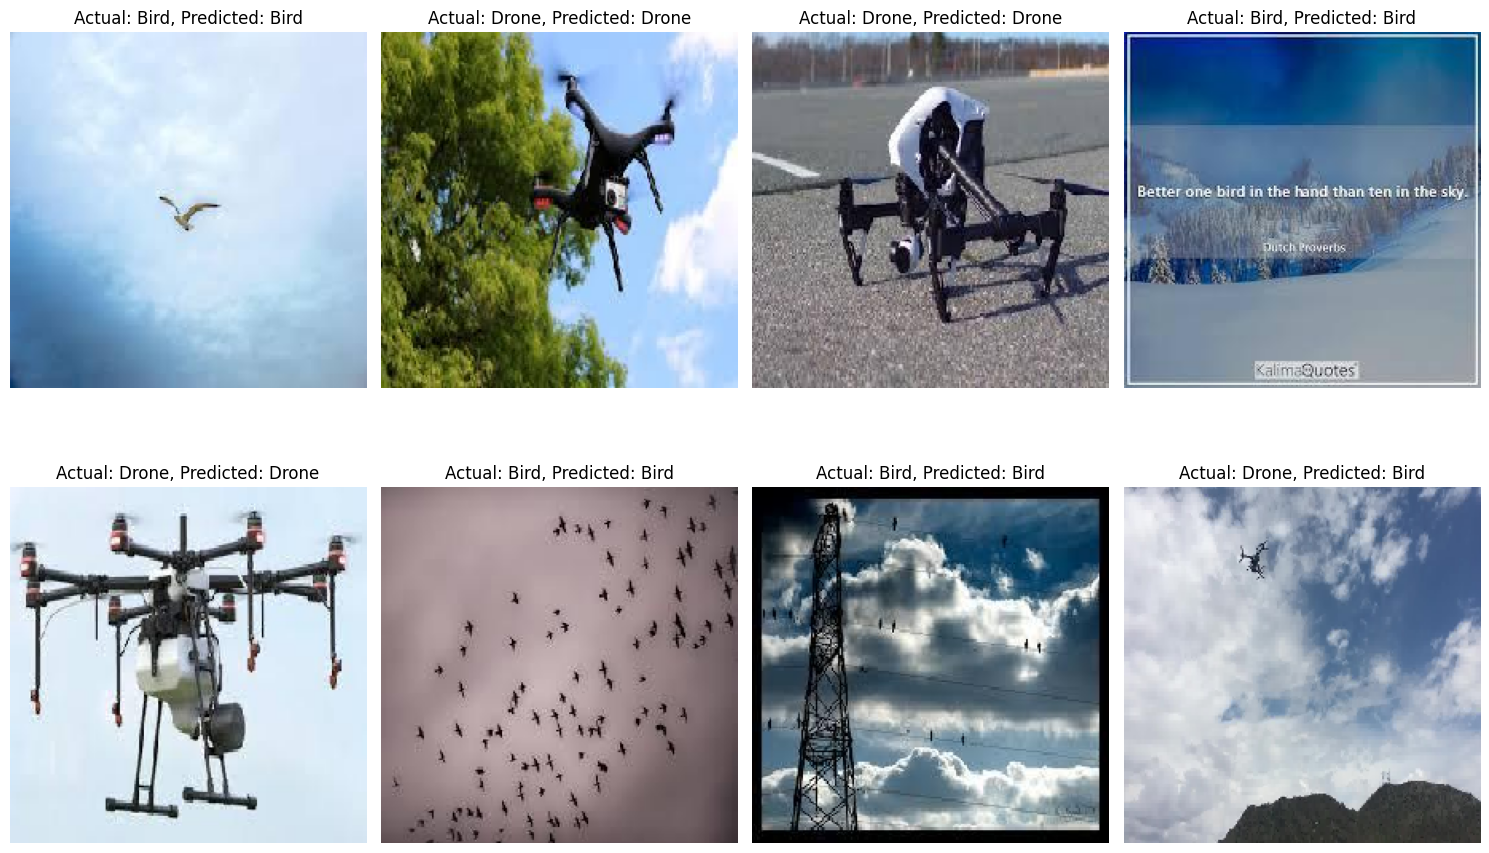

In [7]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Define the path to your test dataset
test_dir = '/content/dataset/BVD/Test/'
class_names = ['Bird', 'Drone']

image_paths = []
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    image_files = os.listdir(class_dir)
    for image_file in image_files:
        image_paths.append(os.path.join(class_dir, image_file))

random_images = random.sample(image_paths, 8)

plt.figure(figsize=(15, 10))

for i, img_path in enumerate(random_images):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    prediction = model.predict(img_array)
    class_label = np.argmax(prediction, axis=1)[0]

    actual_class = img_path.split('/')[-2]

    # Display the image
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f'Actual: {actual_class}, Predicted: {class_names[class_label]}')

plt.tight_layout()
plt.show()


### Grad-CAM Visualization for Bird vs Drone Classification


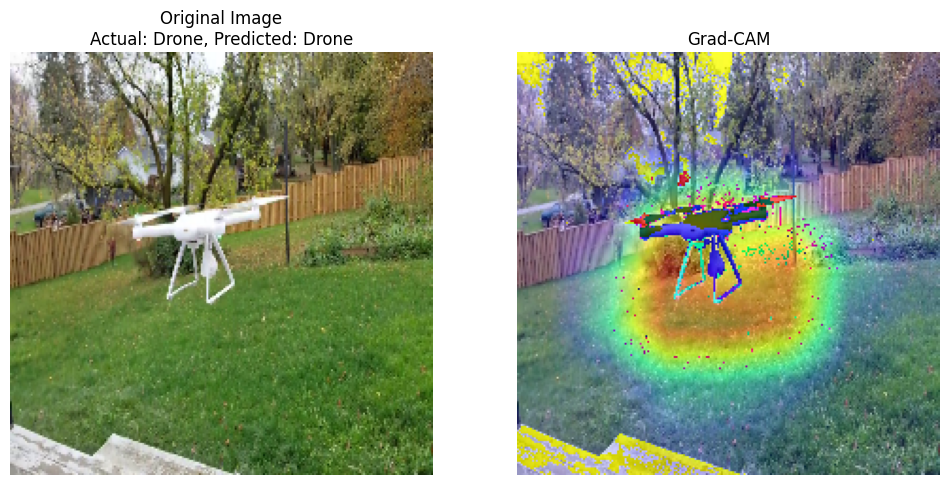

Actual Class: Drone
Predicted Class: Drone


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras import backend as K
from keras.preprocessing import image
import os

test_dir = '/content/dataset/BVD/Test/'
class_names = ['Bird', 'Drone']

image_paths = []
for class_name in class_names:
    class_dir = os.path.join(test_dir, class_name)
    image_files = os.listdir(class_dir)
    for image_file in image_files:
        image_paths.append(os.path.join(class_dir, image_file))

image_path = random.choice(image_paths)

img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

last_conv_layer = model.get_layer("conv5_block3_out")

grad_model = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])

# Compute Gradients and Get Heatmap
with tf.GradientTape() as tape:
    model_output, conv_layer_output = grad_model(img_array)
    class_index = np.argmax(model_output[0])
    grads = tape.gradient(model_output[0][class_index], conv_layer_output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1))

heatmap = np.zeros(conv_layer_output.shape[2])

for i in range(len(pooled_grads)):
    heatmap += pooled_grads[i] * conv_layer_output[0, :, :, i]

# Compute the Heatmap
heatmap = K.relu(heatmap)
heatmap /= K.max(heatmap)

original_img = cv2.imread(image_path)
original_img = cv2.resize(original_img, (224, 224))

heatmap_resized = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))

heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

superimposed_img = heatmap_colored * 0.4 + original_img

actual_class = image_path.split('/')[-2]
predicted_class = class_names[class_index]

# Display the Images with Class Labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title(f'Original Image\nActual: {actual_class}, Predicted: {predicted_class}')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

# Print Actual and Predicted Classes
print(f'Actual Class: {actual_class}')
print(f'Predicted Class: {predicted_class}')
